# Participez à un concours sur la Smart City

# Sommaire :
 - <a href="#C1">Importation des données</a>
 
**Partie 1 : Présentation du jeu de données**
 - <a href="#C2">Présentation du jeu de données</a>
 - <a href="#C3">Dimensions</a>
 - <a href="#C4">Variables</a>
 
**Partie 2 : Nettoyez le jeu de données**
 - <a href="#C5">Nettoyez le jeu de données</a>
 - <a href="#C6">Les valeurs manquantes pour le genre</a>
 - <a href="#C7">Les valeurs manquantes pour la domanialite</a>
 - <a href="#C8">Les Outliers de la circonference et de la hauteur</a>
 - <a href="#C9">Les stades de developpements manquants</a>
 - <a href="#C10">Les valeurs manquantes des remarquables</a>
 - <a href="#C11">Les duplicatas sur les position</a>

Import python lib

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Import csv data

In [4]:
data = pd.read_csv('p2-arbres-fr.csv', delimiter=";", encoding='utf-8')
display(data.head())

,id,type_emplacement,domanialite,arrondissement,complement_addresse,numero,lieu,id_emplacement,libelle_francais,genre,espece,variete,circonference_cm,hauteur_m,stade_developpement,remarquable,geo_point_2d_a,geo_point_2d_b
0,99874,Arbre,Jardin,PARIS 7E ARRDT,NaN,NaN,MAIRIE DU 7E 116 RUE DE GRENELLE PARIS 7E,19,Marronnier,Aesculus,hippocastanum,NaN,20,5,NaN,0.0,48.857620,2.320962
1,99875,Arbre,Jardin,PARIS 7E ARRDT,NaN,NaN,MAIRIE DU 7E 116 RUE DE GRENELLE PARIS 7E,20,If,Taxus,baccata,NaN,65,8,A,NaN,48.857656,2.321031
2,99876,Arbre,Jardin,PARIS 7E ARRDT,NaN,NaN,MAIRIE DU 7E 116 RUE DE GRENELLE PARIS 7E,21,If,Taxus,baccata,NaN,90,10,A,NaN,48.857705,2.321061
3,99877,Arbre,Jardin,PARIS 7E ARRDT,NaN,NaN,MAIRIE DU 7E 116 RUE DE GRENELLE PARIS 7E,22,Erable,Acer,negundo,NaN,60,8,A,NaN,48.857722,2.321006
4,99878,Arbre,Jardin,PARIS 17E ARRDT,NaN,NaN,PARC CLICHY-BATIGNOLLES-MARTIN LUTHER KING,000G0037,Arbre à miel,Tetradium,daniellii,NaN,38,0,NaN,NaN,48.890435,2.315289


Lance tous les traitements de nettoyage de donnees

In [6]:
# genre
data_wt_gender_null = data.loc[~data['genre'].isnull() ,:]

# domanialite
data_wt_gender_null.loc[data['domanialite'].isnull() ,'domanialite'] = 'Jardin'

# stade de dev en fonction de hauteur
mask_1 = (data_wt_gender_null['stade_developpement'].isnull()) & (data_wt_gender_null['circonference_cm'] > 0 )
mask= mask_1 & (data_wt_gender_null['hauteur_m'] >= 15)
data_wt_gender_null.loc[mask, 'stade_developpement'] = 'M'

mask= mask_1 & (data_wt_gender_null['hauteur_m'] >= 10)
data_wt_gender_null.loc[mask, 'stade_developpement'] = 'A'

mask= mask_1 & (data_wt_gender_null['hauteur_m'] >= 7)
data_wt_gender_null.loc[mask, 'stade_developpement'] = 'JA'

mask= mask_1 & (data_wt_gender_null['hauteur_m'] > 0)
data_wt_gender_null.loc[mask, 'stade_developpement'] = 'J'

# stade de developpement en fonction d'une hauteur nulle et d'une circonference positive
mask= (data_wt_gender_null['stade_developpement'].isnull()) & ((data_wt_gender_null['circonference_cm'] > 0 )& (data_wt_gender_null['hauteur_m'] == 0))
data_wt_gender_null = data_wt_gender_null[~mask]

# stade de developpement en fonction d'une hauteur positive et d'une circonference nulle
mask= (data_wt_gender_null['stade_developpement'].isnull()) & ((data_wt_gender_null['circonference_cm'] == 0 )& (data_wt_gender_null['hauteur_m'] > 0))
data_wt_gender_null = data_wt_gender_null[~mask]

# stade de developpement en fonction d'une hauteur nulle et d'une circonference nulle
mask= (data_wt_gender_null['stade_developpement'].isnull()) & ((data_wt_gender_null['circonference_cm'] == 0 )& (data_wt_gender_null['hauteur_m'] == 0))
data_wt_gender_null.loc[mask, 'stade_developpement'] = 'P'

# circonference et hauteur
data_wt_gender_null=data_wt_gender_null[(data_wt_gender_null['circonference_cm']<1000) & (data_wt_gender_null['hauteur_m']<60)]
stade_dev=data_wt_gender_null['stade_developpement'].unique()
for stade in stade_dev:
    for column in ["circonference_cm", "hauteur_m"]:
        mask = (data_wt_gender_null['stade_developpement']== stade)
        stade_dev = data_wt_gender_null.loc[mask,:]
        q1 = stade_dev[column].quantile(q=0.25)
        q3 = stade_dev[column].quantile(q=0.75)
        ecart_inter = q3 - q1
        borne_inf = q1 - 1.5*ecart_inter
        borne_sup = q3 + 1.5*ecart_inter
        data_wt_gender_null.loc[(mask) & ((data_wt_gender_null[column]< borne_inf) | (data_wt_gender_null[column]> borne_sup)),column] = stade_dev[column].mean()

# remarquables
data_wt_gender_null.loc[data_wt_gender_null['remarquable'].isnull(), 'remarquable'] = 0.0

# duplicatas positions
data_wt_gender_null = data_wt_gender_null.drop_duplicates(subset=['id_emplacement', 'arrondissement', 'geo_point_2d_a', 'geo_point_2d_b' ], keep='last')

In [7]:
data_wt_gender_null.isnull().sum()

id                          0
type_emplacement            0
domanialite                 0
arrondissement              0
complement_addresse    156866
numero                 187628
lieu                        0
id_emplacement              0
libelle_francais         1477
genre                       0
espece                   1570
variete                153385
circonference_cm            0
hauteur_m                   0
stade_developpement         0
remarquable                 0
geo_point_2d_a              0
geo_point_2d_b              0
dtype: int64

# <a name="C2">Partie 1 : Présentation du jeu de données</a>

## <a name="C3">Dimensions</a>

In [5]:
data.shape

(200137, 18)

## <a name="C4">Variables</a>

In [6]:
data.dtypes

id                       int64
type_emplacement        object
domanialite             object
arrondissement          object
complement_addresse     object
numero                 float64
lieu                    object
id_emplacement          object
libelle_francais        object
genre                   object
espece                  object
variete                 object
circonference_cm         int64
hauteur_m                int64
stade_developpement     object
remarquable            float64
geo_point_2d_a         float64
geo_point_2d_b         float64
dtype: object

Description des donnees :

In [7]:
data.describe(include='all')

,id,type_emplacement,domanialite,arrondissement,complement_addresse,numero,lieu,id_emplacement,libelle_francais,genre,espece,variete,circonference_cm,hauteur_m,stade_developpement,remarquable,geo_point_2d_a,geo_point_2d_b
count,2.001370e+05,200137,200136,200137,30902,0.0,200137,200137,198640,200121,198385,36777,200137.000000,200137.000000,132932,137039.000000,200137.000000,200137.000000
unique,NaN,1,9,25,3795,NaN,6921,69040,192,175,539,436,NaN,NaN,4,NaN,NaN,NaN
top,NaN,Arbre,Alignement,PARIS 15E ARRDT,SN°,NaN,PARC FLORAL DE PARIS / ROUTE DE LA PYRAMIDE,101001,Platane,Platanus,x hispanica,Baumannii',NaN,NaN,A,NaN,NaN,NaN
freq,NaN,200137,104949,17151,557,NaN,2995,1324,42508,42591,36409,4538,NaN,NaN,64438,NaN,NaN,NaN
mean,3.872027e+05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,83.380479,13.110509,NaN,0.001343,48.854491,2.348208
std,5.456032e+05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,673.190213,1971.217387,NaN,0.036618,0.030234,0.051220
min,9.987400e+04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,0.000000,48.742290,2.210241
25%,1.559270e+05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.000000,5.000000,NaN,0.000000,48.835021,2.307530
50%,2.210780e+05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,70.000000,8.000000,NaN,0.000000,48.854162,2.351095
75%,2.741020e+05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,115.000000,12.000000,NaN,0.000000,48.876447,2.386838


Desccription des donnees 

id
type_emplacement
domanialite	arrondissement
complement_addresse	numero	
lieu	
id_emplacement	
libelle_francais	
genre	
espece	
variete	
circonference_cm	
hauteur_m	
stade_developpement	
remarquable	
geo_point_2d_a	
geo_point_2d_b

# <a name="C5">II - Nettoyez un jeu de données</a>

In [8]:
data.isnull().sum()

id                          0
type_emplacement            0
domanialite                 1
arrondissement              0
complement_addresse    169235
numero                 200137
lieu                        0
id_emplacement              0
libelle_francais         1497
genre                      16
espece                   1752
variete                163360
circonference_cm            0
hauteur_m                   0
stade_developpement     67205
remarquable             63098
geo_point_2d_a              0
geo_point_2d_b              0
dtype: int64

## <a name="C6">Les valeurs manquantes pour le genre </a>

In [9]:
data.loc[data['genre'].isnull() ,:].describe(include='all')

,id,type_emplacement,domanialite,arrondissement,complement_addresse,numero,lieu,id_emplacement,libelle_francais,genre,espece,variete,circonference_cm,hauteur_m,stade_developpement,remarquable,geo_point_2d_a,geo_point_2d_b
count,1.600000e+01,16,16,16,0,0.0,16,16,0,0,0,0,16.0,16.0,0,16.0,16.000000,16.000000
unique,NaN,1,1,1,0,NaN,1,16,0,0,0,0,NaN,NaN,0,NaN,NaN,NaN
top,NaN,Arbre,Jardin,PARIS 13E ARRDT,NaN,NaN,PC13 - JARDIN DE LA RUE DE LA POTERNE DES PEUP...,102027,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,16,16,16,NaN,NaN,16,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,2.018928e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0.0,48.821295,2.352747
std,4.013311e+01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.000047,0.001352
min,2.018848e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0.0,48.821229,2.350885
25%,2.018920e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0.0,48.821261,2.351346
50%,2.018944e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0.0,48.821289,2.353275
75%,2.018952e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0.0,48.821300,2.353932


Les arbes qui ont un genre nuls, ne possedent pas de taille et de circonferences. Il n'y aucune autre information qui nous permettrait de pouvoir completer les donnes manquantes, j'ai donc choisit de faire un sous echantillon pour les extraires.

In [10]:
data_wt_gender_null = data.loc[~data['genre'].isnull() ,:]
data_wt_gender_null.isnull().sum()

id                          0
type_emplacement            0
domanialite                 1
arrondissement              0
complement_addresse    169219
numero                 200121
lieu                        0
id_emplacement              0
libelle_francais         1481
genre                       0
espece                   1736
variete                163344
circonference_cm            0
hauteur_m                   0
stade_developpement     67189
remarquable             63098
geo_point_2d_a              0
geo_point_2d_b              0
dtype: int64

## <a name="C7">Les valeurs manquantes pour la domanialite </a>

In [11]:
domanialite_null = data_wt_gender_null.loc[data['domanialite'].isnull() ,:]
display(domanialite_null)

,id,type_emplacement,domanialite,arrondissement,complement_addresse,numero,lieu,id_emplacement,libelle_francais,genre,espece,variete,circonference_cm,hauteur_m,stade_developpement,remarquable,geo_point_2d_a,geo_point_2d_b
197239,2020911,Arbre,NaN,PARIS 20E ARRDT,NaN,NaN,JARDINS D IMMEUBLES PORTE DE VINCENNES NORD / ...,203006,Chimonanthe,Chimonanthus,praecox,NaN,35,4,JA,0.0,48.849547,2.41419


Le seul individu qui ne possede de domanialite est ce dernier. Cela semble etre une valeur manquante. A l'aide du lieu il est facile de lui en attribuer une nouvelle

In [12]:
data_wt_gender_null.loc[data['lieu'] == domanialite_null.iloc[0,6] ,:]

,id,type_emplacement,domanialite,arrondissement,complement_addresse,numero,lieu,id_emplacement,libelle_francais,genre,espece,variete,circonference_cm,hauteur_m,stade_developpement,remarquable,geo_point_2d_a,geo_point_2d_b
10470,112685,Arbre,Jardin,PARIS 20E ARRDT,NaN,NaN,JARDINS D IMMEUBLES PORTE DE VINCENNES NORD / ...,105004,Pommier à fleurs,Malus,trilobata,NaN,35,4,JA,0.0,48.849399,2.414360
10471,112686,Arbre,Jardin,PARIS 20E ARRDT,NaN,NaN,JARDINS D IMMEUBLES PORTE DE VINCENNES NORD / ...,105005,Peuplier,Populus,alba,Pyramidalis',330,18,M,0.0,48.849375,2.414330
10472,112687,Arbre,Jardin,PARIS 20E ARRDT,NaN,NaN,JARDINS D IMMEUBLES PORTE DE VINCENNES NORD / ...,105003,Sophora,Sophora,japonica,NaN,120,12,A,0.0,48.849446,2.414183
10646,112915,Arbre,Jardin,PARIS 20E ARRDT,NaN,NaN,JARDINS D IMMEUBLES PORTE DE VINCENNES NORD / ...,102002,Tilleul,Tilia,platyphyllos,NaN,140,16,A,0.0,48.849841,2.413391
10647,112916,Arbre,Jardin,PARIS 20E ARRDT,NaN,NaN,JARDINS D IMMEUBLES PORTE DE VINCENNES NORD / ...,102003,Tilleul,Tilia,platyphyllos,NaN,120,16,A,0.0,48.849874,2.413448
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197248,2020920,Arbre,Jardin,PARIS 20E ARRDT,NaN,NaN,JARDINS D IMMEUBLES PORTE DE VINCENNES NORD / ...,201007,Prunus Fleur n. sp.,Prunus,Fleur n. sp.,NaN,15,4,J,0.0,48.849770,2.413760
197249,2020921,Arbre,Jardin,PARIS 20E ARRDT,NaN,NaN,JARDINS D IMMEUBLES PORTE DE VINCENNES NORD / ...,201012,Pommier à fruits,Malus,Fruit n. sp.,NaN,20,4,J,0.0,48.849658,2.413831
197250,2020922,Arbre,Jardin,PARIS 20E ARRDT,NaN,NaN,JARDINS D IMMEUBLES PORTE DE VINCENNES NORD / ...,202003,Prunus Fleur n. sp.,Prunus,Fleur n. sp.,NaN,20,3,J,0.0,48.849599,2.413899
197251,2020923,Arbre,Jardin,PARIS 20E ARRDT,NaN,NaN,JARDINS D IMMEUBLES PORTE DE VINCENNES NORD / ...,201006,Prunus Fleur n. sp.,Prunus,Fleur n. sp.,NaN,25,3,J,0.0,48.849759,2.413875


On observe que tous les individus possedant le meme lieu, possedent la domanialite 'Jardin'. C'est donc celle ci que je vais atribuer à l'individu manquant

In [13]:
data_wt_gender_null.loc[data['domanialite'].isnull() ,'domanialite'] = 'Jardin'
data_wt_gender_null.isnull().sum()

id                          0
type_emplacement            0
domanialite                 0
arrondissement              0
complement_addresse    169219
numero                 200121
lieu                        0
id_emplacement              0
libelle_francais         1481
genre                       0
espece                   1736
variete                163344
circonference_cm            0
hauteur_m                   0
stade_developpement     67189
remarquable             63098
geo_point_2d_a              0
geo_point_2d_b              0
dtype: int64

<AxesSubplot:xlabel='id', ylabel='domanialite'>

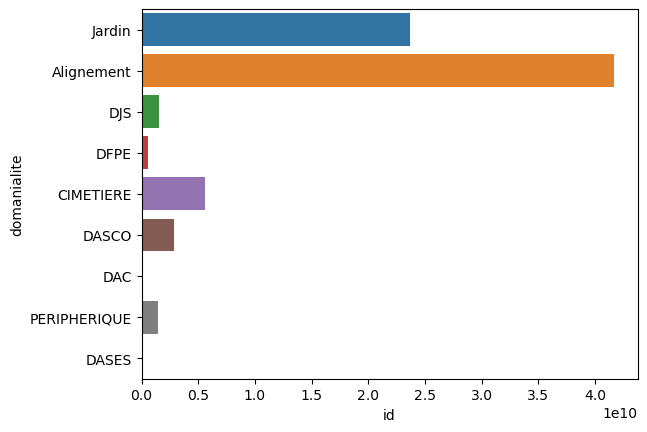

In [14]:
sns.barplot(data=data_wt_gender_null, 
x='id', 
y='domanialite', 
ci=None, estimator=sum)

## <a name="C8">Les Outliers de la circonference et de la hauteur</a>

<AxesSubplot:xlabel='stade_developpement', ylabel='circonference_cm'>

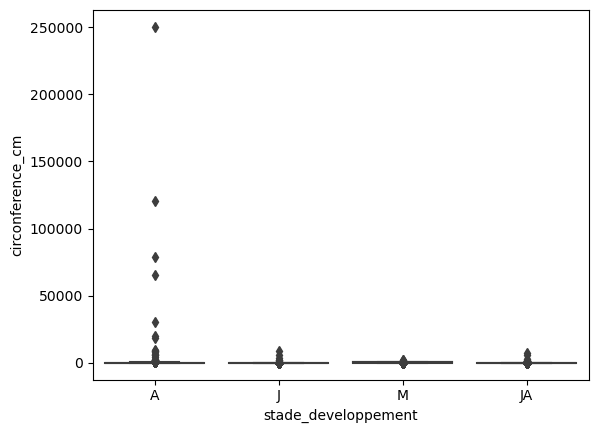

In [15]:
sns.boxplot(x=data_wt_gender_null["stade_developpement"] ,y=data_wt_gender_null["circonference_cm"])

<AxesSubplot:xlabel='stade_developpement', ylabel='hauteur_m'>

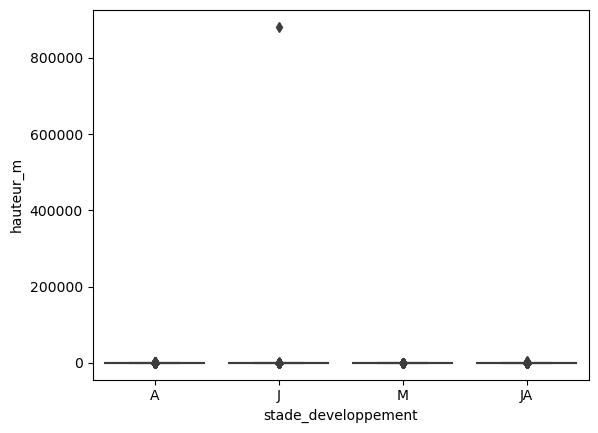

In [16]:
sns.boxplot(x=data_wt_gender_null["stade_developpement"] ,y=data_wt_gender_null["hauteur_m"])

On peut constater qu'il y a des outliers pour la circonference. Je vais d'abord tenter d'isoler les valeurs superieures à 20 000cm

Je constate qu'il y a des valeurs qui sont nettements plus anormales. Pour ne pas que cela fausse le calcul de mes moyennes dans les prochaines etapes, je prends la decision de m'en separer.

In [17]:
data_wt_gender_null=data_wt_gender_null[(data_wt_gender_null['circonference_cm']<800) & (data_wt_gender_null['hauteur_m']<60)]

<AxesSubplot:xlabel='stade_developpement', ylabel='circonference_cm'>

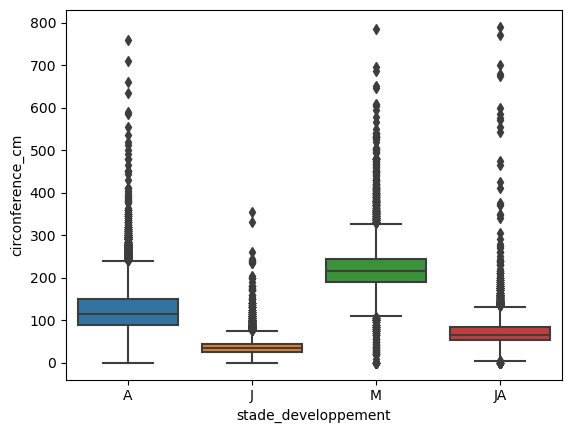

In [18]:
sns.boxplot(x=data_wt_gender_null["stade_developpement"] ,y=data_wt_gender_null["circonference_cm"])

<AxesSubplot:xlabel='stade_developpement', ylabel='hauteur_m'>

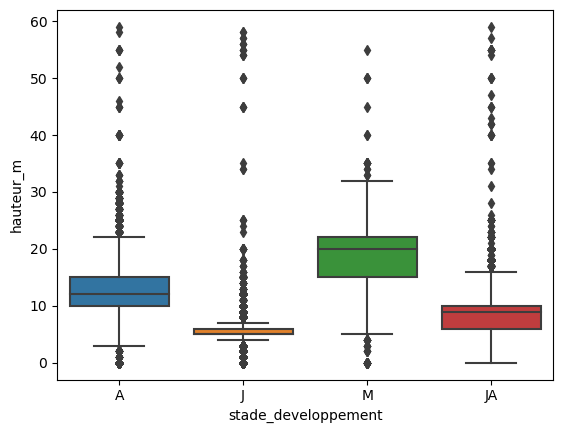

In [19]:
sns.boxplot(x=data_wt_gender_null["stade_developpement"] ,y=data_wt_gender_null["hauteur_m"])

In [20]:
stade_dev=data_wt_gender_null['stade_developpement'].unique()

In [21]:
for stade in stade_dev:
    for column in ["circonference_cm", "hauteur_m"]:
        mask = (data_wt_gender_null['stade_developpement']== stade)
        stade_dev = data_wt_gender_null.loc[mask,:]
        q1 = stade_dev[column].quantile(q=0.25)
        q3 = stade_dev[column].quantile(q=0.75)
        ecart_inter = q3 - q1
        borne_inf = q1 - 1.5*ecart_inter
        borne_sup = q3 + 1.5*ecart_inter
        data_wt_gender_null.loc[(mask) & ((data_wt_gender_null[column]< borne_inf) | (data_wt_gender_null[column]> borne_sup)),column] = stade_dev[column].mean()

<AxesSubplot:xlabel='stade_developpement', ylabel='circonference_cm'>

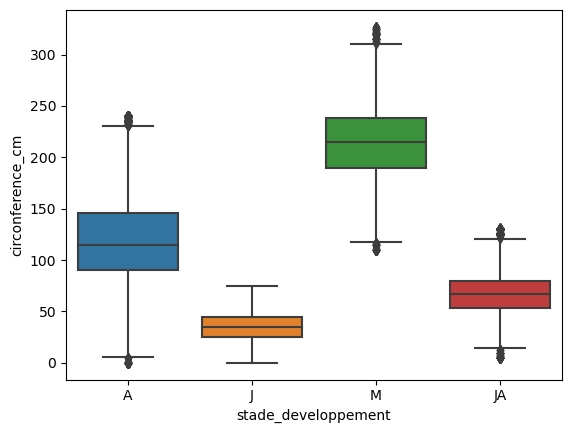

In [22]:
sns.boxplot(x=data_wt_gender_null["stade_developpement"] ,y=data_wt_gender_null["circonference_cm"])

<AxesSubplot:xlabel='stade_developpement', ylabel='hauteur_m'>

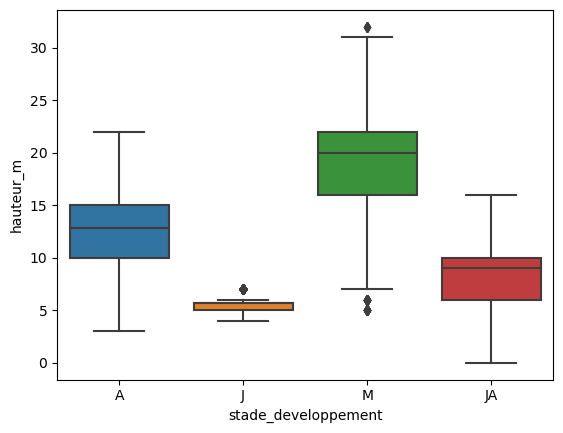

In [23]:
sns.boxplot(x=data_wt_gender_null["stade_developpement"] ,y=data_wt_gender_null["hauteur_m"])

Ressource utilisés pour cette etape:
https://datascientest.com/data-cleaning
https://fr.khanacademy.org/math/be-4eme-secondaire2/x213a6fc6f6c9e122:statistiques/x213a6fc6f6c9e122:boite-a-moustaches-et-analyse-de-donnees/a/identifying-outliers-iqr-rule

## <a name="C9">Les stades de developpements manquants</a>

In [24]:
data_wt_gender_null.isnull().sum()

id                          0
type_emplacement            0
domanialite                 0
arrondissement              0
complement_addresse    168805
numero                 199635
lieu                        0
id_emplacement              0
libelle_francais         1480
genre                       0
espece                   1735
variete                162897
circonference_cm            0
hauteur_m                   0
stade_developpement     67183
remarquable             63092
geo_point_2d_a              0
geo_point_2d_b              0
dtype: int64

### 1. Hauteur et circonference superieures a 0 :

In [25]:
mask= (data_wt_gender_null['stade_developpement'].isnull()) & ((data_wt_gender_null['circonference_cm'] > 0 )& (data_wt_gender_null['hauteur_m'] > 0))
data_wt_gender_null.loc[mask, :]

,id,type_emplacement,domanialite,arrondissement,complement_addresse,numero,lieu,id_emplacement,libelle_francais,genre,espece,variete,circonference_cm,hauteur_m,stade_developpement,remarquable,geo_point_2d_a,geo_point_2d_b
0,99874,Arbre,Jardin,PARIS 7E ARRDT,NaN,NaN,MAIRIE DU 7E 116 RUE DE GRENELLE PARIS 7E,19,Marronnier,Aesculus,hippocastanum,NaN,20.0,5.0,NaN,0.0,48.857620,2.320962
7,99881,Arbre,Jardin,PARIS 16E ARRDT,NaN,NaN,SQUARE ALEXANDRE ET RENE PARODI / 1 PLACE DE L...,35,Platane,Platanus,x hispanica,NaN,260.0,17.0,NaN,NaN,48.876722,2.280222
80,99959,Arbre,Jardin,PARIS 4E ARRDT,NaN,NaN,JARDIN DE LA CITE INTERNATIONALE DES ARTS,3,Pommier,Malus,n. sp.,NaN,40.0,4.0,NaN,NaN,48.854069,2.358229
81,99960,Arbre,Jardin,PARIS 4E ARRDT,NaN,NaN,JARDIN DE LA CITE INTERNATIONALE DES ARTS,4,Bouleau,Betula,pendula,NaN,75.0,11.0,NaN,NaN,48.854351,2.357613
82,99961,Arbre,Jardin,PARIS 4E ARRDT,NaN,NaN,JARDIN DE LA CITE INTERNATIONALE DES ARTS,5,Bouleau,Betula,pendula,NaN,80.0,10.0,NaN,NaN,48.854294,2.357535
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
198874,2023464,Arbre,Alignement,PARIS 20E ARRDT,8,NaN,RUE DU GENERAL NIESSEL,202002,Chêne,Quercus,cerris,NaN,20.0,5.0,NaN,0.0,48.848074,2.409116
198875,2023465,Arbre,Alignement,PARIS 20E ARRDT,8,NaN,RUE DU GENERAL NIESSEL,202003,Chêne,Quercus,cerris,NaN,20.0,5.0,NaN,0.0,48.848226,2.409147
198876,2023466,Arbre,Alignement,PARIS 20E ARRDT,10,NaN,RUE DU GENERAL NIESSEL,202004,Chêne,Quercus,cerris,NaN,20.0,5.0,NaN,0.0,48.848379,2.409179
198877,2023467,Arbre,Alignement,PARIS 20E ARRDT,12,NaN,RUE DU GENERAL NIESSEL,202005,Chêne,Quercus,cerris,NaN,20.0,5.0,NaN,0.0,48.848533,2.409209


Dans un premier temps j'isole les stades de developpement qui possedent des arbres avec une circonference et une hauteur superieure à 0. Je vais ensuite leur attribuer un stade de developpement en fonction de leur hauteur, en me servant des donnees recoltées dans l'étape précédente.
Ainsi, je definis qu'un arbre est Jeune lorsque sa hauteur est inferieure à 7m, que c'est un jeune adulte lorsque sa hauteur est comprise entre 7m et 10m, que c'est un arbre adulte pour 10 a 15m et qu'il est mature à partir de 15m.

In [26]:
mask_1 = (data_wt_gender_null['stade_developpement'].isnull()) & (data_wt_gender_null['circonference_cm'] > 0 )
mask= mask_1 & (data_wt_gender_null['hauteur_m'] >= 15)
data_wt_gender_null.loc[mask, 'stade_developpement'] = 'M'

mask= mask_1 & (data_wt_gender_null['hauteur_m'] >= 10)
data_wt_gender_null.loc[mask, 'stade_developpement'] = 'A'

mask= mask_1 & (data_wt_gender_null['hauteur_m'] >= 7)
data_wt_gender_null.loc[mask, 'stade_developpement'] = 'JA'

mask= mask_1 & (data_wt_gender_null['hauteur_m'] > 0)
data_wt_gender_null.loc[mask, 'stade_developpement'] = 'J'

data_wt_gender_null.loc[mask, :]

,id,type_emplacement,domanialite,arrondissement,complement_addresse,numero,lieu,id_emplacement,libelle_francais,genre,espece,variete,circonference_cm,hauteur_m,stade_developpement,remarquable,geo_point_2d_a,geo_point_2d_b
0,99874,Arbre,Jardin,PARIS 7E ARRDT,NaN,NaN,MAIRIE DU 7E 116 RUE DE GRENELLE PARIS 7E,19,Marronnier,Aesculus,hippocastanum,NaN,20.0,5.0,J,0.0,48.857620,2.320962
7,99881,Arbre,Jardin,PARIS 16E ARRDT,NaN,NaN,SQUARE ALEXANDRE ET RENE PARODI / 1 PLACE DE L...,35,Platane,Platanus,x hispanica,NaN,260.0,17.0,J,NaN,48.876722,2.280222
80,99959,Arbre,Jardin,PARIS 4E ARRDT,NaN,NaN,JARDIN DE LA CITE INTERNATIONALE DES ARTS,3,Pommier,Malus,n. sp.,NaN,40.0,4.0,J,NaN,48.854069,2.358229
81,99960,Arbre,Jardin,PARIS 4E ARRDT,NaN,NaN,JARDIN DE LA CITE INTERNATIONALE DES ARTS,4,Bouleau,Betula,pendula,NaN,75.0,11.0,J,NaN,48.854351,2.357613
82,99961,Arbre,Jardin,PARIS 4E ARRDT,NaN,NaN,JARDIN DE LA CITE INTERNATIONALE DES ARTS,5,Bouleau,Betula,pendula,NaN,80.0,10.0,J,NaN,48.854294,2.357535
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
198874,2023464,Arbre,Alignement,PARIS 20E ARRDT,8,NaN,RUE DU GENERAL NIESSEL,202002,Chêne,Quercus,cerris,NaN,20.0,5.0,J,0.0,48.848074,2.409116
198875,2023465,Arbre,Alignement,PARIS 20E ARRDT,8,NaN,RUE DU GENERAL NIESSEL,202003,Chêne,Quercus,cerris,NaN,20.0,5.0,J,0.0,48.848226,2.409147
198876,2023466,Arbre,Alignement,PARIS 20E ARRDT,10,NaN,RUE DU GENERAL NIESSEL,202004,Chêne,Quercus,cerris,NaN,20.0,5.0,J,0.0,48.848379,2.409179
198877,2023467,Arbre,Alignement,PARIS 20E ARRDT,12,NaN,RUE DU GENERAL NIESSEL,202005,Chêne,Quercus,cerris,NaN,20.0,5.0,J,0.0,48.848533,2.409209


### 2. Circonferences superieures a 0 :

In [27]:
mask= (data_wt_gender_null['stade_developpement'].isnull()) & ((data_wt_gender_null['circonference_cm'] > 0 )& (data_wt_gender_null['hauteur_m'] == 0))
data_wt_gender_null.loc[mask, :].sort_values(by='circonference_cm')

,id,type_emplacement,domanialite,arrondissement,complement_addresse,numero,lieu,id_emplacement,libelle_francais,genre,espece,variete,circonference_cm,hauteur_m,stade_developpement,remarquable,geo_point_2d_a,geo_point_2d_b
62043,168272,Arbre,CIMETIERE,PARIS 19E ARRDT,NaN,NaN,CIMETIERE DE LA VILLETTE / AVENUE PRINCIPALE /...,A14000001005,Tilleul,Tilia,n. sp.,NaN,10.0,0.0,NaN,NaN,48.884558,2.388262
141,100021,Arbre,Jardin,PARIS 16E ARRDT,NaN,NaN,JARDIN DU GENERAL ANSELIN / 1 AVENUE DE POLOGNE,43,Robinier,Robinia,pseudoacacia,NaN,10.0,0.0,NaN,0.0,48.869005,2.271867
77025,196220,Arbre,PERIPHERIQUE,PARIS 18E ARRDT,NaN,NaN,TALUS N°23-50,92350017,Platane,Platanus,x hispanica,NaN,10.0,0.0,NaN,NaN,48.900772,2.365280
143,100023,Arbre,Jardin,PARIS 16E ARRDT,NaN,NaN,JARDIN DU GENERAL ANSELIN / 1 AVENUE DE POLOGNE,47,Cèdre,Cedrus,libani,NaN,10.0,0.0,NaN,0.0,48.869086,2.271961
8828,110875,Arbre,Jardin,PARIS 20E ARRDT,NaN,NaN,SQUARE LEON FRAPIE,48,Amélanchier,Amelanchier,lamarckii,NaN,10.0,0.0,NaN,NaN,48.872742,2.412331
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34297,139635,Arbre,Jardin,PARIS 16E ARRDT,NaN,NaN,PLACE DU MARECHAL DE LATTRE DE TASSIGNY,22,Marronnier,Aesculus,hippocastanum,NaN,460.0,0.0,NaN,NaN,48.871929,2.274393
23111,127124,Arbre,Jardin,PARIS 15E ARRDT,NaN,NaN,SQUARE OISEAU LUNAIRE,34,Thuya,Thuja,plicata,Atrovirens',550.0,0.0,NaN,NaN,48.841699,2.305270
23112,127125,Arbre,Jardin,PARIS 15E ARRDT,NaN,NaN,SQUARE OISEAU LUNAIRE,35,Parrotie de Perse - Arbre de fer,Parrotia,persica,NaN,550.0,0.0,NaN,NaN,48.841836,2.305260
24649,128792,Arbre,Jardin,PARIS 15E ARRDT,NaN,NaN,JARDIN DE L'ATLANTIQUE,185,Cerisier à fleurs,Prunus,x subhirtella,NaN,650.0,0.0,NaN,NaN,48.839288,2.318946


J'ai decide de les éliminer car il etait complique de determiner si c'etait des pousses ou des souches

In [28]:
data_wt_gender_null = data_wt_gender_null[~mask]
display(data_wt_gender_null)

,id,type_emplacement,domanialite,arrondissement,complement_addresse,numero,lieu,id_emplacement,libelle_francais,genre,espece,variete,circonference_cm,hauteur_m,stade_developpement,remarquable,geo_point_2d_a,geo_point_2d_b
0,99874,Arbre,Jardin,PARIS 7E ARRDT,NaN,NaN,MAIRIE DU 7E 116 RUE DE GRENELLE PARIS 7E,19,Marronnier,Aesculus,hippocastanum,NaN,20.0,5.0,J,0.0,48.857620,2.320962
1,99875,Arbre,Jardin,PARIS 7E ARRDT,NaN,NaN,MAIRIE DU 7E 116 RUE DE GRENELLE PARIS 7E,20,If,Taxus,baccata,NaN,65.0,8.0,A,NaN,48.857656,2.321031
2,99876,Arbre,Jardin,PARIS 7E ARRDT,NaN,NaN,MAIRIE DU 7E 116 RUE DE GRENELLE PARIS 7E,21,If,Taxus,baccata,NaN,90.0,10.0,A,NaN,48.857705,2.321061
3,99877,Arbre,Jardin,PARIS 7E ARRDT,NaN,NaN,MAIRIE DU 7E 116 RUE DE GRENELLE PARIS 7E,22,Erable,Acer,negundo,NaN,60.0,8.0,A,NaN,48.857722,2.321006
7,99881,Arbre,Jardin,PARIS 16E ARRDT,NaN,NaN,SQUARE ALEXANDRE ET RENE PARODI / 1 PLACE DE L...,35,Platane,Platanus,x hispanica,NaN,260.0,17.0,J,NaN,48.876722,2.280222
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200132,2024741,Arbre,Jardin,BOIS DE VINCENNES,NaN,NaN,ARBORETUM DE L ECOLE DU BREUIL - ROUTE DE LA F...,720170151,NaN,Castanea,fargesii,NaN,0.0,0.0,NaN,0.0,48.821957,2.456264
200133,2024742,Arbre,Jardin,BOIS DE VINCENNES,NaN,NaN,ARBORETUM DE L ECOLE DU BREUIL - ROUTE DE LA F...,720170152,Arbre aux mouchoirs,Davidia,involucrata,NaN,0.0,0.0,NaN,0.0,48.823254,2.457935
200134,2024743,Arbre,Jardin,BOIS DE VINCENNES,NaN,NaN,ARBORETUM DE L ECOLE DU BREUIL - ROUTE DE LA F...,720170153,Peuplier,Populus,simonii,NaN,0.0,0.0,NaN,0.0,48.822907,2.457970
200135,2024744,Arbre,Jardin,BOIS DE VINCENNES,NaN,NaN,ARBORETUM DE L ECOLE DU BREUIL - ROUTE DE LA F...,720170154,Chêne,Quercus,n. sp.,NaN,0.0,0.0,NaN,0.0,48.822522,2.455956


### 3. Hauteurs superieures à 0 :

De la meme maniere je vais éliminer les arbres qui ont une circonference de 0 cm mais qui possèdent une hauteur

In [29]:
mask= (data_wt_gender_null['stade_developpement'].isnull()) & ((data_wt_gender_null['circonference_cm'] == 0 )& (data_wt_gender_null['hauteur_m'] > 0))
data_wt_gender_null.loc[mask, :].sort_values(by='hauteur_m')

,id,type_emplacement,domanialite,arrondissement,complement_addresse,numero,lieu,id_emplacement,libelle_francais,genre,espece,variete,circonference_cm,hauteur_m,stade_developpement,remarquable,geo_point_2d_a,geo_point_2d_b
28256,132674,Arbre,Jardin,PARIS 5E ARRDT,NaN,NaN,SQUARE DES ARENES DE LUTECE,80,Figuier,Ficus,carica,NaN,0.0,1.0,NaN,NaN,48.845038,2.353764
15747,118803,Arbre,Jardin,PARIS 7E ARRDT,NaN,NaN,SQUARE BOUCICAUT,42,Palmier,Brahea,armata,NaN,0.0,1.0,NaN,NaN,48.851266,2.325353
15771,118829,Arbre,Jardin,PARIS 7E ARRDT,NaN,NaN,SQUARE BOUCICAUT,68,Palmier,Brahea,armata,NaN,0.0,1.0,NaN,NaN,48.851483,2.325968
29975,134562,Arbre,Jardin,PARIS 12E ARRDT,NaN,NaN,JARDIN DEBERGUE- RENDEZ VOUS / 30 RUE DU RENDE...,73,Lilas des indes,Lagerstroemia,indica,NaN,0.0,2.0,NaN,NaN,48.846653,2.404399
26699,130927,Arbre,Jardin,PARIS 15E ARRDT,NaN,NaN,PARC OMNISPORT SUZANNE LENGLEN / 7 BOULEVARD D...,10159,Laurier du Portugal,Prunus,lusitanica,NaN,0.0,2.0,NaN,NaN,48.832004,2.272608
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24578,128712,Arbre,Jardin,PARIS 15E ARRDT,NaN,NaN,JARDIN DE L'ATLANTIQUE,199,Pin,Pinus,sylvestris,NaN,0.0,45.0,NaN,NaN,48.839883,2.319665
24605,128743,Arbre,Jardin,PARIS 15E ARRDT,NaN,NaN,JARDIN DE L'ATLANTIQUE,135,Arbre de Judée,Cercis,siliquastrum,NaN,0.0,45.0,NaN,NaN,48.839456,2.319324
24607,128745,Arbre,Jardin,PARIS 15E ARRDT,NaN,NaN,JARDIN DE L'ATLANTIQUE,137,Hêtre,Fagus,sylvatica,Pendula',0.0,45.0,NaN,NaN,48.839288,2.319373
24402,128508,Arbre,Jardin,PARIS 15E ARRDT,NaN,NaN,JARDIN DE L'ATLANTIQUE,123,Eleagnus - Chalef,Elaeagnus,angustifolia,NaN,0.0,45.0,NaN,NaN,48.839585,2.319417


In [30]:
data_wt_gender_null = data_wt_gender_null[~mask]
display(data_wt_gender_null)

,id,type_emplacement,domanialite,arrondissement,complement_addresse,numero,lieu,id_emplacement,libelle_francais,genre,espece,variete,circonference_cm,hauteur_m,stade_developpement,remarquable,geo_point_2d_a,geo_point_2d_b
0,99874,Arbre,Jardin,PARIS 7E ARRDT,NaN,NaN,MAIRIE DU 7E 116 RUE DE GRENELLE PARIS 7E,19,Marronnier,Aesculus,hippocastanum,NaN,20.0,5.0,J,0.0,48.857620,2.320962
1,99875,Arbre,Jardin,PARIS 7E ARRDT,NaN,NaN,MAIRIE DU 7E 116 RUE DE GRENELLE PARIS 7E,20,If,Taxus,baccata,NaN,65.0,8.0,A,NaN,48.857656,2.321031
2,99876,Arbre,Jardin,PARIS 7E ARRDT,NaN,NaN,MAIRIE DU 7E 116 RUE DE GRENELLE PARIS 7E,21,If,Taxus,baccata,NaN,90.0,10.0,A,NaN,48.857705,2.321061
3,99877,Arbre,Jardin,PARIS 7E ARRDT,NaN,NaN,MAIRIE DU 7E 116 RUE DE GRENELLE PARIS 7E,22,Erable,Acer,negundo,NaN,60.0,8.0,A,NaN,48.857722,2.321006
7,99881,Arbre,Jardin,PARIS 16E ARRDT,NaN,NaN,SQUARE ALEXANDRE ET RENE PARODI / 1 PLACE DE L...,35,Platane,Platanus,x hispanica,NaN,260.0,17.0,J,NaN,48.876722,2.280222
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200132,2024741,Arbre,Jardin,BOIS DE VINCENNES,NaN,NaN,ARBORETUM DE L ECOLE DU BREUIL - ROUTE DE LA F...,720170151,NaN,Castanea,fargesii,NaN,0.0,0.0,NaN,0.0,48.821957,2.456264
200133,2024742,Arbre,Jardin,BOIS DE VINCENNES,NaN,NaN,ARBORETUM DE L ECOLE DU BREUIL - ROUTE DE LA F...,720170152,Arbre aux mouchoirs,Davidia,involucrata,NaN,0.0,0.0,NaN,0.0,48.823254,2.457935
200134,2024743,Arbre,Jardin,BOIS DE VINCENNES,NaN,NaN,ARBORETUM DE L ECOLE DU BREUIL - ROUTE DE LA F...,720170153,Peuplier,Populus,simonii,NaN,0.0,0.0,NaN,0.0,48.822907,2.457970
200135,2024744,Arbre,Jardin,BOIS DE VINCENNES,NaN,NaN,ARBORETUM DE L ECOLE DU BREUIL - ROUTE DE LA F...,720170154,Chêne,Quercus,n. sp.,NaN,0.0,0.0,NaN,0.0,48.822522,2.455956


### 4. Hauteurs et Circonferences nulles :

In [31]:
mask= (data_wt_gender_null['stade_developpement'].isnull()) & ((data_wt_gender_null['circonference_cm'] == 0 )& (data_wt_gender_null['hauteur_m'] == 0))
data_wt_gender_null.loc[mask, :].sort_values(by='hauteur_m')

,id,type_emplacement,domanialite,arrondissement,complement_addresse,numero,lieu,id_emplacement,libelle_francais,genre,espece,variete,circonference_cm,hauteur_m,stade_developpement,remarquable,geo_point_2d_a,geo_point_2d_b
1778,101922,Arbre,Jardin,PARIS 19E ARRDT,NaN,NaN,PARC DES BUTTES CHAUMONT,C0400032,Erable,Acer,platanoides,NaN,0.0,0.0,NaN,NaN,48.879620,2.384927
63550,169781,Arbre,CIMETIERE,HAUTS-DE-SEINE,NaN,NaN,CIMETIERE DE BAGNEUX / AVENUE DES TILLEULS DE ...,A09000066007,Tilleul,Tilia,platyphyllos,NaN,0.0,0.0,NaN,NaN,48.804682,2.309563
63549,169780,Arbre,CIMETIERE,HAUTS-DE-SEINE,NaN,NaN,CIMETIERE DE BAGNEUX / AVENUE DES TILLEULS DE ...,A09000066006,Tilleul,Tilia,platyphyllos,NaN,0.0,0.0,NaN,NaN,48.804728,2.309610
63548,169779,Arbre,CIMETIERE,HAUTS-DE-SEINE,NaN,NaN,CIMETIERE DE BAGNEUX / AVENUE DES TILLEULS DE ...,A09000066005,Tilleul,Tilia,platyphyllos,NaN,0.0,0.0,NaN,NaN,48.804774,2.309656
63547,169778,Arbre,CIMETIERE,HAUTS-DE-SEINE,NaN,NaN,CIMETIERE DE BAGNEUX / AVENUE DES TILLEULS DE ...,A09000066004,Tilleul,Tilia,platyphyllos,NaN,0.0,0.0,NaN,NaN,48.804817,2.309699
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45703,151406,Arbre,CIMETIERE,HAUTS-DE-SEINE,NaN,NaN,CIMETIERE DE BAGNEUX / AVENUE DES AULNES / DIV 71,A04400071004,Aulne,Alnus,cordata,NaN,0.0,0.0,NaN,NaN,48.806124,2.305415
45702,151405,Arbre,CIMETIERE,HAUTS-DE-SEINE,NaN,NaN,CIMETIERE DE BAGNEUX / AVENUE DES AULNES / DIV 71,A04400071003,Aulne,Alnus,cordata,NaN,0.0,0.0,NaN,NaN,48.806156,2.305338
45701,151404,Arbre,CIMETIERE,HAUTS-DE-SEINE,NaN,NaN,CIMETIERE DE BAGNEUX / AVENUE DES AULNES / DIV 71,A04400071002,Aulne,Alnus,cordata,NaN,0.0,0.0,NaN,NaN,48.806193,2.305245
45699,151402,Arbre,CIMETIERE,HAUTS-DE-SEINE,NaN,NaN,CIMETIERE DE BAGNEUX / AVENUE DES AULNES / DIV 79,A04400079008,Aulne,Alnus,cordata,NaN,0.0,0.0,NaN,NaN,48.806184,2.305084


Dans le cas ou un arbre possedent une hauteur et une circonference égale à 0 on peut considerer que ce sont peut etre des pousses. J'ai decide de les conserver, mais de leur attribuer une categorie à part entiere que j'ai nommé 'Pousse' ('P')

In [32]:
data_wt_gender_null.loc[mask, 'stade_developpement'] = 'P'

In [33]:
data_wt_gender_null.isnull().sum()

id                          0
type_emplacement            0
domanialite                 0
arrondissement              0
complement_addresse    156865
numero                 187626
lieu                        0
id_emplacement              0
libelle_francais         1477
genre                       0
espece                   1570
variete                153383
circonference_cm            0
hauteur_m                   0
stade_developpement         0
remarquable             52073
geo_point_2d_a              0
geo_point_2d_b              0
dtype: int64

<AxesSubplot:xlabel='stade_developpement', ylabel='circonference_cm'>

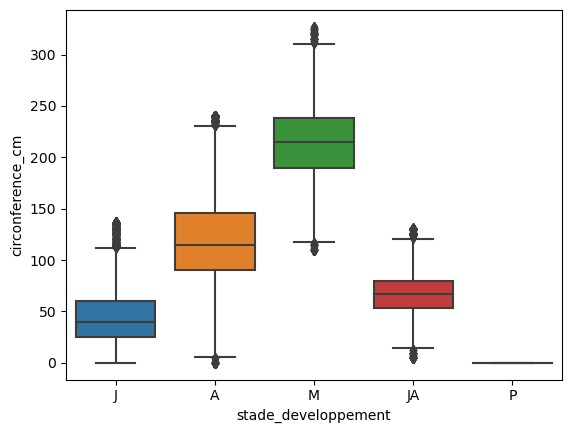

In [63]:
sns.boxplot(x=data_wt_gender_null["stade_developpement"] ,y=data_wt_gender_null["circonference_cm"])

<AxesSubplot:xlabel='stade_developpement', ylabel='hauteur_m'>

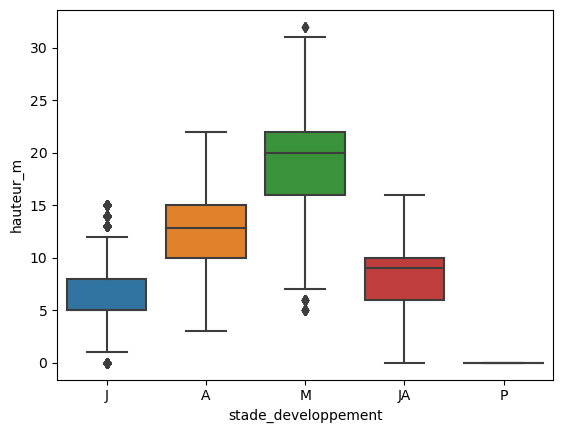

In [64]:
sns.boxplot(x=data_wt_gender_null["stade_developpement"] ,y=data_wt_gender_null["hauteur_m"])

## <a name="C10">Les valeurs manquantes des remarquables</a>

Pour les remarquables je juge que je ne suis pas capable d'estimer ou non si un arbre est remarquable. Par consequent je vais attribuer une valeur par defaut negative à tout ceux qui n'en possèdent pas.

In [36]:
data_wt_gender_null.loc[data_wt_gender_null['remarquable'].isnull(), 'remarquable'] = 0.0
data_wt_gender_null.isnull().sum()

id                          0
type_emplacement            0
domanialite                 0
arrondissement              0
complement_addresse    156865
numero                 187626
lieu                        0
id_emplacement              0
libelle_francais         1477
genre                       0
espece                   1570
variete                153383
circonference_cm            0
hauteur_m                   0
stade_developpement         0
remarquable                 0
geo_point_2d_a              0
geo_point_2d_b              0
dtype: int64

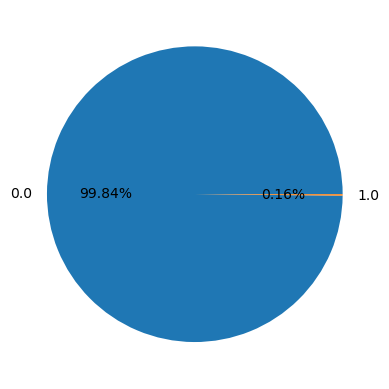

In [37]:
data_remarquable = data_wt_gender_null.groupby('remarquable')['id'].sum().reset_index()
plt.pie(x=data_remarquable['id'], labels=data_remarquable['remarquable'], autopct='%.2f%%')
plt.show()

## <a name="C11">Les duplicatas sur les positions</a>

Pour etre sure qu'un arbre occcupe une position unique, je cherche les duplicats d'une position en comparant sont id_emplacement, son arrodissement, et ses coordonées géographiques. J'obtiens un résultat pour une paire. Je vais conserver la deuxième occurences.

In [38]:
data_wt_gender_null.loc[data_wt_gender_null.duplicated(subset=['id_emplacement', 'arrondissement', 'geo_point_2d_a', 'geo_point_2d_b' ], keep=False),:].sort_values(by=['id_emplacement'])

,id,type_emplacement,domanialite,arrondissement,complement_addresse,numero,lieu,id_emplacement,libelle_francais,genre,espece,variete,circonference_cm,hauteur_m,stade_developpement,remarquable,geo_point_2d_a,geo_point_2d_b
189133,2011522,Arbre,Jardin,BOIS DE VINCENNES,NaN,NaN,PARC FLORAL DE PARIS / ROUTE DE LA PYRAMIDE,190042,Peuplier,Populus,nigra,NaN,0.0,0.0,P,0.0,48.836416,2.446277
189134,2011523,Arbre,Jardin,BOIS DE VINCENNES,NaN,NaN,PARC FLORAL DE PARIS / ROUTE DE LA PYRAMIDE,190042,Peuplier,Populus,nigra,Italica',100.0,22.0,A,0.0,48.836416,2.446277


In [39]:
data_wt_gender_null = data_wt_gender_null.drop_duplicates(subset=['id_emplacement', 'arrondissement', 'geo_point_2d_a', 'geo_point_2d_b' ], keep='last')

## <a name="C12">Exemples conclusion</a>

Organisation par arrondissement

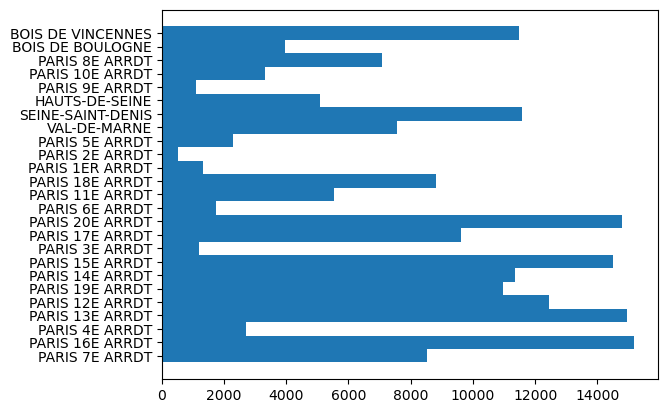

In [70]:
plt.hist(data_wt_gender_null['arrondissement'], orientation='horizontal', bins=range(0,26), align='left')
plt.show() 

Exemple de répartition pour le 14eme arrondissement.

In [14]:
data_arr = data_wt_gender_null.loc[data_wt_gender_null['arrondissement']=='PARIS 14E ARRDT', :]
display(data_arr.head())

,id,type_emplacement,domanialite,arrondissement,complement_addresse,numero,lieu,id_emplacement,libelle_francais,genre,espece,variete,circonference_cm,hauteur_m,stade_developpement,remarquable,geo_point_2d_a,geo_point_2d_b
1915,102086,Arbre,Jardin,PARIS 14E ARRDT,NaN,NaN,PARC MONTSOURIS,000O0083,Pin,Pinus,nigra,NaN,157.000000,18.000000,A,0.0,48.821643,2.340703
1916,102087,Arbre,Jardin,PARIS 14E ARRDT,NaN,NaN,PARC MONTSOURIS,000O0081,Cèdre,Cedrus,libani,NaN,195.000000,12.877796,A,0.0,48.821596,2.340551
1917,102088,Arbre,Jardin,PARIS 14E ARRDT,NaN,NaN,PARC MONTSOURIS,000O0080,Cèdre,Cedrus,libani,NaN,58.109715,7.104488,J,0.0,48.821554,2.340530
1918,102090,Arbre,Jardin,PARIS 14E ARRDT,NaN,NaN,PARC MONTSOURIS,000O0078,Cèdre,Cedrus,libani,NaN,271.000000,25.000000,M,0.0,48.821445,2.340734
1919,102091,Arbre,Jardin,PARIS 14E ARRDT,NaN,NaN,PARC MONTSOURIS,000O0077,If,Taxus,baccata,NaN,100.000000,15.000000,J,0.0,48.821449,2.340566


Repartition par domanialité:

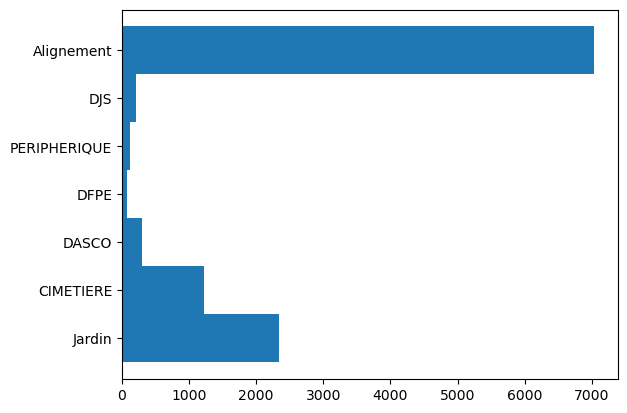

In [76]:
plt.hist(data_arr['domanialite'], orientation='horizontal', bins=range(0,8), align='left')
plt.show() 

Repartition par stade d'évolution:

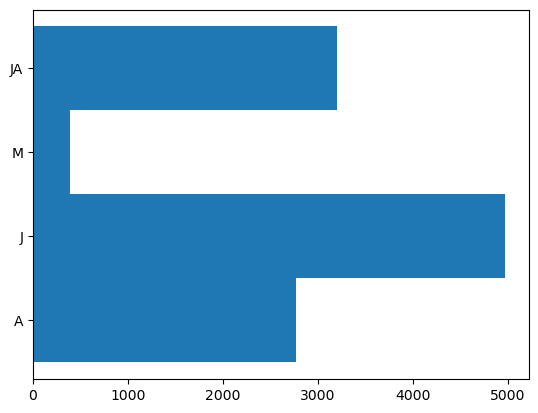

In [80]:
plt.hist(data_arr['stade_developpement'],orientation='horizontal', bins=range(0,5), align='left')
plt.show() 